# GPT Fine-tuning Pipeline for Startup Pitches

This notebook provides a complete workflow for fine-tuning a small GPT-2 model on a niche dataset of startup pitches. We'll go through:

1. Setting up the environment
2. Preparing the dataset
3. Fine-tuning the model
4. Evaluating performance
5. Testing the fine-tuned model

Let's get started!


## 1. Environment Setup

First, let's install the required libraries:


In [2]:
# Install required packages
!pip install transformers datasets torch evaluate nltk rouge_score pandas matplotlib seaborn tqdm

In [3]:
import json
import logging
import os
import sys
import traceback
import warnings
from abc import ABC, abstractmethod
from dataclasses import dataclass, asdict
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union, Any
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback,
    set_seed
)
from datasets import load_metric
import evaluate
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import wandb
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
transformers.logging.set_verbosity_error()


In [4]:
# Download NLTK data with error handling
try:
    nltk.download('punkt', quiet=True)
except Exception as e:
    print(f"Warning: Could not download NLTK data: {e}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 📦 Configuration and Logging Setup

This section defines key configuration classes and a custom logger used throughout the GPT fine-tuning pipeline.

### 🔧 `ModelConfig`
Defines hyperparameters and model-specific settings for training:
- `model_name`: Name of the base model (default: `"gpt2"`).
- `max_length`: Maximum sequence length.
- `learning_rate`, `batch_size`, `num_epochs`, `warmup_steps`: Core training hyperparameters.
- `weight_decay`: Regularization term.
- `save_steps`, `eval_steps`, `logging_steps`: Frequency of saving, evaluation, and logging.
- `save_total_limit`: Max number of model checkpoints to retain.
- `load_best_model_at_end`: Whether to reload the best checkpoint after training.
- `metric_for_best_model`: Metric used to evaluate the best model.
- `early_stopping_patience`: Number of evaluations with no improvement before stopping.
- `fp16`: Enables mixed precision training.
- `gradient_accumulation_steps`: Number of steps to accumulate gradients before backward/update.
- `dataloader_num_workers`: Workers used in data loading.

### 🏋️‍♀️ `TrainingConfig`
Specifies paths and environment settings:
- `data_path`: Location of the dataset.
- `output_dir`, `logs_dir`: Where to store trained models and logs.
- `train_split`, `val_split`, `test_split`: Dataset split ratios.
- `random_seed`: Ensures reproducibility.
- `use_wandb`: Enable/disable Weights & Biases integration.
- `wandb_project`, `experiment_name`: Project naming for tracking experiments.

### 📊 `EvaluationMetrics`
A data class to store model evaluation metrics:
- Includes `perplexity`, `BLEU`, `ROUGE` scores, average prediction length, and number of samples.
- `to_dict()` converts metrics into a dictionary format for easy logging or saving.

### 📝 `Logger`
A custom logger that supports both console and file outputs:
- Initializes with a name and optional log file path.
- Automatically creates directory structure if it doesn't exist.
- Supports four log levels: `info`, `warning`, `error`, and `debug`.
- Ensures no duplicate handlers are added across runs.

This modular configuration structure ensures flexibility, easy experimentation, and clean separation of concerns.


In [65]:
@dataclass
class ModelConfig:
    """Configuration class for model parameters."""
    model_name: str = "gpt2"
    max_length: int = 128
    learning_rate: float = 5e-5
    batch_size: int = 4
    num_epochs: int = 5
    warmup_steps: int = 100
    weight_decay: float = 0.01
    save_steps: int = 500
    eval_steps: int = 100
    logging_steps: int = 50
    save_total_limit: int = 3
    load_best_model_at_end: bool = True
    metric_for_best_model: str = "eval_loss"
    greater_is_better: bool = False
    early_stopping_patience: int = 3
    fp16: bool = True
    gradient_accumulation_steps: int = 1
    dataloader_num_workers: int = 2


@dataclass
class TrainingConfig:
    """Configuration class for training parameters."""
    data_path: str = "./data"
    output_dir: str = "./models"
    logs_dir: str = "./logs"
    train_split: float = 0.7
    val_split: float = 0.2
    test_split: float = 0.1
    random_seed: int = 42
    use_wandb: bool = False
    wandb_project: str = "startup-pitch-gpt"
    experiment_name: str = "baseline"


@dataclass
class EvaluationMetrics:
    """Data class for storing evaluation metrics."""
    perplexity: float
    bleu_score: float
    rouge1: float
    rouge2: float
    rougeL: float
    avg_prediction_length: float
    total_samples: int

    def to_dict(self) -> Dict:
        return asdict(self)


class Logger:
    """Custom logger with file and console output."""

    def __init__(self, name: str, log_file: Optional[str] = None, level: int = logging.INFO):
        self.logger = logging.getLogger(name)
        self.logger.setLevel(level)

        # Remove existing handlers to avoid duplicates
        for handler in self.logger.handlers[:]:
            self.logger.removeHandler(handler)

        # Create formatter
        formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        )

        # Console handler
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        self.logger.addHandler(console_handler)

        # File handler
        if log_file:
            os.makedirs(os.path.dirname(log_file), exist_ok=True)
            file_handler = logging.FileHandler(log_file)
            file_handler.setFormatter(formatter)
            self.logger.addHandler(file_handler)

    def info(self, message: str):
        self.logger.info(message)

    def warning(self, message: str):
        self.logger.warning(message)

    def error(self, message: str):
        self.logger.error(message)

    def debug(self, message: str):
        self.logger.debug(message)


## 🔍 Data Validation Class

The `DataValidator` class provides static methods to ensure input data quality and format correctness before training.

### Method: `validate_startup_pitch_data`

- **Purpose:**  
  Validates a list of startup pitch data samples, checking each item for required fields and content constraints.

- **Input:**  
  - `data` (List of dictionaries): Each dictionary should contain `"input"` and `"output"` fields representing the prompt and expected model response.

- **Validation Checks:**  
  - Each item must be a dictionary.  
  - Required fields `"input"` and `"output"` must be present.  
  - Input and output texts must not be empty.  
  - Input text length must be between 3 and 200 characters.  
  - Output text length must be between 5 and 500 characters.

- **Output:**  
  - `cleaned_data`: List of validated data items with trimmed input and output texts.  
  - `errors`: List of error messages describing any validation failures by item index.

- **Usage:**  
  This function helps clean and filter data prior to training, ensuring only valid samples are used and providing useful feedback for data correction.


In [66]:
class DataValidator:
    """Validates input data quality and format."""

    @staticmethod
    def validate_startup_pitch_data(data: List[Dict]) -> Tuple[List[Dict], List[str]]:
        """Validate startup pitch data and return cleaned data with error messages."""
        cleaned_data = []
        errors = []

        for i, item in enumerate(data):
            try:
                # Check required fields
                if not isinstance(item, dict):
                    errors.append(f"Item {i}: Not a dictionary")
                    continue

                if "input" not in item or "output" not in item:
                    errors.append(f"Item {i}: Missing 'input' or 'output' field")
                    continue

                # Validate field types and content
                input_text = str(item["input"]).strip()
                output_text = str(item["output"]).strip()

                if len(input_text) == 0:
                    errors.append(f"Item {i}: Empty input text")
                    continue

                if len(output_text) == 0:
                    errors.append(f"Item {i}: Empty output text")
                    continue

                if len(input_text) < 3:
                    errors.append(f"Item {i}: Input text too short (< 3 characters)")
                    continue

                if len(output_text) < 5:
                    errors.append(f"Item {i}: Output text too short (< 5 characters)")
                    continue

                # Check for reasonable length limits
                if len(input_text) > 200:
                    errors.append(f"Item {i}: Input text too long (> 200 characters)")
                    continue

                if len(output_text) > 500:
                    errors.append(f"Item {i}: Output text too long (> 500 characters)")
                    continue

                cleaned_data.append({
                    "input": input_text,
                    "output": output_text
                })

            except Exception as e:
                errors.append(f"Item {i}: Error processing - {str(e)}")

        return cleaned_data, errors


## 📦 StartupPitchDataset Class

The `StartupPitchDataset` class is a PyTorch `Dataset` designed to tokenize and structure startup pitch data for language model training.

### Purpose
Converts a list of input-output text samples into tokenized PyTorch tensors suitable for training causal language models.

### Inputs
- `data` (List[Dict]): Each dictionary must contain `"input"` and `"output"` fields with text strings.
- `tokenizer`: A tokenizer compatible with the language model being trained (e.g., HuggingFace tokenizer).
- `max_length` (int): Maximum token length for each example (default: 128).

### Functionality
- Concatenates `"input"` and `"output"` for each sample.
- Tokenizes the combined text with padding and truncation.
- Converts tokenized outputs into:
  - `input_ids`: Token IDs.
  - `attention_mask`: Mask to distinguish real tokens from padding.
  - `labels`: Same as `input_ids`, with padding tokens replaced by `-100` for loss masking.

### Output
Returns a dictionary for each sample:
- `input_ids`: Tensor of token IDs.
- `attention_mask`: Tensor of attention mask values.
- `labels`: Tensor for training with padding tokens ignored.

### Usage
Used in a `DataLoader` to iterate over formatted training data for a language model.

---

## 🧹 DataProcessor Class

The `DataProcessor` class handles the loading and preparation of startup pitch data for training.

### Purpose
Encapsulates the data ingestion, validation, and structuring logic for training datasets.

### Initialization
- `config`: Configuration object containing data paths or training settings.
- `logger`: Logger instance for logging operations and validation results.

### Key Methods

#### `load_startup_pitch_data()`
- **Purpose:** Loads a static list of mock startup pitch samples.
- **Output:** List of dictionaries, each containing:
  - `"input"`: The beginning of a pitch sentence.
  - `"output"`: The completion/idea of the pitch.

### Example Use
Used to supply the raw dataset before validation and dataset wrapping.


In [67]:
class StartupPitchDataset(Dataset):
    """PyTorch Dataset for startup pitch data."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        example = self.data[idx]
        full_text = example["input"] + example["output"]

        try:
            encoding = self.tokenizer(
                full_text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )

            input_ids = encoding["input_ids"].squeeze()
            attention_mask = encoding["attention_mask"].squeeze()

            # Create labels (same as input_ids for causal language modeling)
            labels = input_ids.clone()
            labels[labels == self.tokenizer.pad_token_id] = -100

            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels
            }
        except Exception as e:
            raise RuntimeError(f"Error tokenizing example {idx}: {str(e)}")


class DataProcessor:
    """Handles data loading, cleaning, and preprocessing."""

    def __init__(self, config: TrainingConfig, logger: Logger):
        self.config = config
        self.logger = logger
        self.validator = DataValidator()

    def load_startup_pitch_data(self) -> List[Dict]:
      """Load startup pitch data (mock data for demonstration)."""
      return [
          {"input": "We are building", "output": " a decentralized platform for pet lovers to share experiences and monetize care tips."},
          {"input": "Our product", "output": " uses AI to personalize grocery shopping for rural communities with poor internet access."},
          {"input": "Our startup", "output": " leverages blockchain to create transparent supply chains for fair-trade coffee producers."},
          {"input": "We've developed", "output": " a wearable device that monitors hydration levels for endurance athletes."},
          {"input": "Our app", "output": " connects elderly individuals with nearby volunteers for quick household assistance."},
          {"input": "We offer", "output": " a subscription service delivering customized STEM projects for middle school students."},
          {"input": "Our platform", "output": " uses computer vision to help farmers identify crop diseases from smartphone photos."},
          {"input": "We're creating", "output": " biodegradable packaging solutions from agricultural waste."},
          {"input": "Our technology", "output": " enables remote monitoring of beehives to protect colony health and improve yields."},
          {"input": "We provide", "output": " an AI writing assistant specifically trained for legal documentation."},
          {"input": "Our company", "output": " develops micro-robots for precision surgery with minimal invasiveness."},
          {"input": "Our mission", "output": " is to make renewable energy accessible to low-income communities through pay-as-you-go solar."},
          {"input": "We built", "output": " a marketplace connecting independent artisans with interior designers seeking custom furnishings."},
          {"input": "Our solution", "output": " uses satellite imagery and ML to predict crop yields for smallholder farmers."},
          {"input": "We specialize in", "output": " converting food waste from restaurants into high-quality compost for urban farms."},
          {"input": "We are launching", "output": " a fintech app that provides micro-loans to underbanked communities in emerging markets."},
          {"input": "Our innovation", "output": " combines IoT sensors with machine learning to optimize water usage in smart cities."},
          {"input": "We're developing", "output": " a virtual reality platform for immersive language learning experiences."},
          {"input": "Our service", "output": " matches skilled refugees with employers seeking diverse talent pools."},
          {"input": "We create", "output": " personalized nutrition plans using genetic data and lifestyle tracking."},
          {"input": "We are pioneering", "output": " a drone delivery system for medical supplies in remote disaster zones."},
          {"input": "Our team", "output": " designs modular housing units for rapid deployment in homeless shelters."},
          {"input": "We deliver", "output": " a cloud-based platform for small businesses to manage carbon footprint tracking."},
          {"input": "Our software", "output": " automates compliance for small-scale manufacturers in regulated industries."},
          {"input": "We’re building", "output": " an augmented reality tool for architects to visualize projects in real-time."},
          {"input": "Our initiative", "output": " promotes literacy by distributing e-readers preloaded with free educational content."},
          {"input": "We invented", "output": " a low-cost filtration system to provide clean drinking water in developing regions."},
          {"input": "Our system", "output": " integrates renewable energy storage for off-grid communities using recycled batteries."},
          {"input": "We’re launching", "output": " a peer-to-peer platform for renting unused backyard spaces for urban gardening."},
          {"input": "Our approach", "output": " combines gamification and AI to boost mental health awareness for teens."},
          {"input": "We empower", "output": " local artisans by providing e-commerce tools to sell crafts globally."},
          {"input": "Our device", "output": " monitors air quality in real-time to alert asthmatics of hazardous conditions."},
          {"input": "We’re designing", "output": " a blockchain-based voting system to ensure secure and transparent elections."},
          {"input": "Our project", "output": " upcycles plastic waste into durable 3D-printed furniture for schools."},
          {"input": "We facilitate", "output": " virtual mentorship programs for underrepresented youth in tech careers."},
          {"input": "We’re introducing", "output": " a mobile app that gamifies recycling to encourage sustainable habits in kids."},
          {"input": "Our venture", "output": " streamlines logistics for small e-commerce businesses with AI-driven route optimization."},
          {"input": "We designed", "output": " a smart thermostat that adapts to user habits to reduce energy costs for renters."},
          {"input": "Our tool", "output": " helps teachers create interactive lesson plans with AI-generated quizzes and visuals."},
          {"input": "We are revolutionizing", "output": " urban mobility with electric scooters powered by swappable solar batteries."},
          {"input": "Our platform connects", "output": " freelance translators with businesses needing real-time multilingual support."},
          {"input": "We’ve created", "output": " a wearable patch that tracks stress levels and suggests mindfulness exercises."},
          {"input": "Our business", "output": " offers AI-powered chatbots tailored for mental health support in workplaces."},
          {"input": "We’re innovating", "output": " with 3D-printed prosthetics customized for children in conflict zones."},
          {"input": "Our application", "output": " uses machine learning to match donors with local nonprofits in real time."},
          {"input": "We are transforming", "output": " waste management with smart bins that sort recyclables automatically."},
          {"input": "Our model", "output": " predicts equipment failures for factories using IoT and predictive analytics."},
          {"input": "We’re crafting", "output": " a social platform for hobbyists to trade rare collectibles securely."},
          {"input": "Our product line", "output": " delivers eco-friendly diapers made from bamboo and biodegradable materials."},
          {"input": "We enable", "output": " remote workers to collaborate via holographic meetings with AR technology."},
          {"input": "Our startup focuses on", "output": " training AI to detect early signs of dementia through speech patterns."},
          {"input": "We’re rolling out", "output": " a subscription box for zero-waste personal care products tailored to skin types."},
          {"input": "Our invention", "output": " captures ocean microplastics using autonomous solar-powered drones."},
          {"input": "We support", "output": " small retailers with a platform for real-time inventory tracking and demand forecasting."},
          {"input": "Our vision", "output": " is to reduce food insecurity with vertical farms powered by renewable energy."},
          {"input": "We’re engineering", "output": " a portable device to test soil fertility for farmers in remote areas."},
          {"input": "Our service provides", "output": " on-demand legal advice for startups via a mobile app with AI triage."},
          {"input": "We are developing", "output": " a platform for crowd-sourced disaster mapping to aid first responders."},
          {"input": "Our tech", "output": " optimizes EV charging stations with AI to reduce wait times in urban areas."},
          {"input": "We’re pioneering", "output": " a peer-to-peer energy trading system for solar panel owners."},
          {"input": "Our program", "output": " trains women in rural areas to code via mobile-based micro-lessons."},
          {"input": "We’ve launched", "output": " an AI tool to simplify tax filing for freelancers and gig workers."},
          {"input": "Our ecosystem", "output": " connects beekeepers with local farmers for pollination services."},
          {"input": "We’re advancing", "output": " telemedicine with a portable diagnostic kit for rural clinics."},
          {"input": "Our strategy", "output": " uses gamified apps to teach financial literacy to young adults."},
          {"input": "We are inventing", "output": " a smart mirror that provides real-time fitness coaching for home workouts."},
          {"input": "Our effort", "output": " reduces textile waste by upcycling old clothes into fashionable accessories."},
          {"input": "We’ve engineered", "output": " a compact hydroponic system for urban dwellers to grow fresh herbs indoors."},
          {"input": "Our network", "output": " links small-scale fishermen with restaurants for sustainable seafood sourcing."},
          {"input": "We’re transforming", "output": " eldercare with AI-powered robots for companionship and daily assistance."},
          {"input": "Our mission includes", "output": " deploying low-cost wind turbines for energy generation in remote islands."},
          {"input": "We are creating", "output": " a platform for virtual art galleries to showcase emerging artists globally."},
          {"input": "Our toolset", "output": " equips nonprofits with AI analytics to measure campaign impact effectively."},
          {"input": "We’re designing", "output": " a wearable translator for real-time communication across language barriers."},
          {"input": "Our company offers", "output": " a blockchain solution for verifying the authenticity of luxury goods."},
          {"input": "We are enhancing", "output": " public safety with AI-driven traffic analysis for accident prevention."},
          {"input": "Our app empowers", "output": " parents with tools to monitor and limit children’s screen time responsibly."},
          {"input": "We’ve pioneered", "output": " a compostable phone case made from plant-based materials and seeds."},
          {"input": "Our platform enables", "output": " peer-to-peer car sharing with integrated insurance and tracking."},
          {"input": "We’re innovating", "output": " with a solar-powered cooler for vaccine transport in off-grid areas."},
          {"input": "Our service streamlines", "output": " event planning with AI to match venues, caterers, and entertainers."},
          {"input": "We are launching", "output": " a digital wallet for kids to learn budgeting with parental oversight."},
          {"input": "Our technology helps", "output": " museums create interactive AR exhibits for enhanced visitor engagement."},
          {"input": "We’re building", "output": " a platform for crowd-funding clean water projects in underserved regions."},
          {"input": "Our solution empowers", "output": " gig workers with a tool to track income and access benefits."},
          {"input": "We provide a", "output": " machine learning model to optimize energy use in commercial buildings."},
          {"input": "Our startup is", "output": " developing eco-friendly paint from recycled materials for sustainable construction."},
          {"input": "We’re revolutionizing", "output": " pet care with a smart collar that tracks health and location."},
          {"input": "Our initiative supports", "output": " indigenous communities with e-learning tools for cultural preservation."},
          {"input": "We are crafting", "output": " a subscription service for monthly DIY repair kits for home appliances."},
          {"input": "Our product enhances", "output": " sleep quality with a smart pillow that adjusts to user movements."},
          {"input": "We’re introducing", "output": " a blockchain registry for land ownership to prevent fraud in rural areas."},
          {"input": "Our team develops", "output": " AI-driven tutoring systems for students with learning disabilities."},
          {"input": "We facilitate", "output": " cross-border remittances with a low-fee, blockchain-based mobile app."},
          {"input": "Our vision includes", "output": " creating modular playgrounds from recycled plastics for urban parks."},
          {"input": "We’re engineering", "output": " a device to convert ocean wave energy into electricity for coastal communities."},
          {"input": "Our approach integrates", "output": " AI and drones to monitor deforestation in real time for conservation."},
          {"input": "We are designing", "output": " a virtual fitting room app for online clothing stores to reduce returns."},
          {"input": "Our service connects", "output": " retired professionals with startups needing part-time expertise."}
      ]

    def process_data(self) -> Tuple[List[Dict], List[Dict], List[Dict]]:
        """Process and split data into train, validation, and test sets."""
        try:
            # Load raw data
            raw_data = self.load_startup_pitch_data()
            self.logger.info(f"Loaded {len(raw_data)} raw samples")

            # Validate data
            cleaned_data, errors = self.validator.validate_startup_pitch_data(raw_data)

            if errors:
                self.logger.warning(f"Data validation found {len(errors)} issues:")
                for error in errors[:5]:  # Show first 5 errors
                    self.logger.warning(f"  - {error}")
                if len(errors) > 5:
                    self.logger.warning(f"  ... and {len(errors) - 5} more issues")

            if len(cleaned_data) == 0:
                raise ValueError("No valid data samples after cleaning")

            self.logger.info(f"Cleaned data: {len(cleaned_data)} valid samples")

            # Split data
            train_data, temp_data = train_test_split(
                cleaned_data,
                train_size=self.config.train_split,
                random_state=self.config.random_seed
            )

            val_size = self.config.val_split / (self.config.val_split + self.config.test_split)
            val_data, test_data = train_test_split(
                temp_data,
                train_size=val_size,
                random_state=self.config.random_seed
            )

            self.logger.info(f"Data split - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

            return train_data, val_data, test_data

        except Exception as e:
            self.logger.error(f"Error processing data: {str(e)}")
            raise



## 🚀 ModelTrainer Class

The `ModelTrainer` class encapsulates the full lifecycle of training a language model using HuggingFace Transformers, from initialization to saving the final model.

### Purpose
Handles model loading, dataset preparation, training configuration, and model training with logging, early stopping, and optional Weights & Biases (W&B) integration.

---

### Method: `__init__`

- **Purpose:**  
  Initializes trainer with configuration and logging setup, and sets the device (CPU or GPU).

- **Parameters:**  
  - `model_config`: Configuration for model hyperparameters.  
  - `training_config`: Configuration for training setup and output directories.  
  - `logger`: Logger instance for monitoring training stages.

---

### Method: `initialize_model_and_tokenizer`

- **Purpose:**  
  Loads the tokenizer and language model from HuggingFace, sets padding tokens, and moves model to the selected device.

- **Key Steps:**  
  - Load GPT-2 tokenizer and model.  
  - Assign `pad_token` if missing.  
  - Configure model to use `eos_token_id` for padding.  
  - Move model to GPU (if available).

---

### Method: `create_datasets`

- **Purpose:**  
  Converts raw training and validation data into tokenized PyTorch datasets.

- **Input:**  
  - `train_data`, `val_data`: Lists of dictionaries with `"input"` and `"output"` fields.

- **Output:**  
  - `train_dataset`, `val_dataset`: Tokenized `StartupPitchDataset` objects.

---

### Method: `setup_training_arguments`

- **Purpose:**  
  Prepares `TrainingArguments` for the HuggingFace `Trainer`.

- **Configuration Includes:**  
  - Output/log directories  
  - Epochs, batch size, gradient accumulation  
  - Learning rate, warmup, weight decay  
  - Logging, evaluation, and saving intervals  
  - W&B integration and run naming  
  - Early stopping and mixed precision training (`fp16`)

---

### Method: `train`

- **Purpose:**  
  Triggers the full training pipeline from data to model saving.

- **Steps:**  
  1. Initialize W&B (if enabled).  
  2. Load model and tokenizer.  
  3. Create datasets.  
  4. Setup training arguments.  
  5. Configure data collator and early stopping.  
  6. Create HuggingFace `Trainer`.  
  7. Train the model and save outputs.  
  8. Log training metrics and clean up W&B.

- **Returns:**  
  - Path to the saved model directory.

- **Logging:**  
  - Each step logs success or failure using the provided logger.  
  - Errors raise exceptions with tracebacks.


In [68]:
class ModelTrainer:
    """Handles model training with comprehensive monitoring."""

    def __init__(self, model_config: ModelConfig, training_config: TrainingConfig, logger: Logger):
        self.model_config = model_config
        self.training_config = training_config
        self.logger = logger
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = None
        self.model = None
        self.trainer = None

        # Set random seeds for reproducibility
        set_seed(training_config.random_seed)

    def initialize_model_and_tokenizer(self):
        """Initialize tokenizer and model."""
        try:
            self.logger.info(f"Loading model: {self.model_config.model_name}")

            # Load tokenizer
            self.tokenizer = GPT2Tokenizer.from_pretrained(self.model_config.model_name)

            # Set padding token
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            # Load model
            self.model = GPT2LMHeadModel.from_pretrained(self.model_config.model_name)
            self.model.config.pad_token_id = self.model.config.eos_token_id

            # Move to device
            self.model.to(self.device)

            self.logger.info(f"Model loaded successfully on {self.device}")
            self.logger.info(f"Model parameters: {self.model.num_parameters():,}")

        except Exception as e:
            self.logger.error(f"Error initializing model: {str(e)}")
            raise

    def create_datasets(self, train_data: List[Dict], val_data: List[Dict]) -> Tuple[StartupPitchDataset, StartupPitchDataset]:
        """Create PyTorch datasets."""
        try:
            train_dataset = StartupPitchDataset(train_data, self.tokenizer, self.model_config.max_length)
            val_dataset = StartupPitchDataset(val_data, self.tokenizer, self.model_config.max_length)

            self.logger.info(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}")

            return train_dataset, val_dataset

        except Exception as e:
            self.logger.error(f"Error creating datasets: {str(e)}")
            raise

    def setup_training_arguments(self) -> TrainingArguments:
        """Setup training arguments."""
        output_dir = Path(self.training_config.output_dir) / self.training_config.experiment_name
        logs_dir = Path(self.training_config.logs_dir) / self.training_config.experiment_name

        return TrainingArguments(
            output_dir=str(output_dir),
            overwrite_output_dir=True,
            num_train_epochs=self.model_config.num_epochs,
            per_device_train_batch_size=self.model_config.batch_size,
            per_device_eval_batch_size=self.model_config.batch_size,
            gradient_accumulation_steps=self.model_config.gradient_accumulation_steps,
            learning_rate=self.model_config.learning_rate,
            weight_decay=self.model_config.weight_decay,
            warmup_steps=self.model_config.warmup_steps,
            logging_dir=str(logs_dir),
            logging_steps=self.model_config.logging_steps,
            eval_steps=self.model_config.eval_steps,
            save_steps=self.model_config.save_steps,
            save_total_limit=self.model_config.save_total_limit,
            eval_strategy="steps",
            load_best_model_at_end=self.model_config.load_best_model_at_end,
            metric_for_best_model=self.model_config.metric_for_best_model,
            greater_is_better=self.model_config.greater_is_better,
            fp16=self.model_config.fp16 and torch.cuda.is_available(),
            dataloader_num_workers=self.model_config.dataloader_num_workers,
            report_to="wandb" if self.training_config.use_wandb else "none",
            run_name=f"{self.training_config.experiment_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        )

    def train(self, train_data: List[Dict], val_data: List[Dict]) -> str:
        """Train the model."""
        try:
            # Initialize W&B if configured
            if self.training_config.use_wandb:
                wandb.init(
                    project=self.training_config.wandb_project,
                    name=self.training_config.experiment_name,
                    config={**asdict(self.model_config), **asdict(self.training_config)}
                )

            # Initialize model and tokenizer
            if self.model is None or self.tokenizer is None:
                self.initialize_model_and_tokenizer()

            # Create datasets
            train_dataset, val_dataset = self.create_datasets(train_data, val_data)

            # Setup training arguments
            training_args = self.setup_training_arguments()

            # Data collator
            data_collator = DataCollatorForLanguageModeling(
                tokenizer=self.tokenizer,
                mlm=False
            )

            # Early stopping callback
            early_stopping = EarlyStoppingCallback(
                early_stopping_patience=self.model_config.early_stopping_patience
            )

            # Initialize trainer
            self.trainer = Trainer(
                model=self.model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                tokenizer=self.tokenizer,
                data_collator=data_collator,
                callbacks=[early_stopping]
            )

            # Start training
            self.logger.info("Starting training...")
            train_result = self.trainer.train()

            # Save model
            output_path = training_args.output_dir
            self.trainer.save_model()
            self.tokenizer.save_pretrained(output_path)

            self.logger.info(f"Training completed. Model saved to: {output_path}")
            last_log = self.trainer.state.log_history[-1] if self.trainer.state.log_history else {}
            train_loss = last_log.get("loss", "N/A")
            self.logger.info(f"Training loss: {train_loss}")


            # Close W&B
            if self.training_config.use_wandb:
                wandb.finish()

            return output_path

        except Exception as e:
            self.logger.error(f"Training failed: {str(e)}")
            self.logger.error(traceback.format_exc())
            raise


## 🧪 ModelEvaluator Class

The `ModelEvaluator` class provides a comprehensive framework for evaluating a trained language model using standard NLP metrics such as BLEU, ROUGE, and perplexity. It also generates detailed result files and visualizations for better model analysis.

### Purpose  
Loads a trained GPT-2 model and tokenizer, performs text generation, evaluates predictions against references using multiple metrics, and saves both aggregate and per-sample evaluation results.

---

### Method: `__init__`

- **Purpose:**  
  Initializes the evaluator with the model path, logger, and metric scorers. Automatically loads the model and tokenizer.

- **Parameters:**  
  - `model_path`: Path to the trained model directory.  
  - `logger`: Logger instance for monitoring evaluation stages.

---

### Method: `_load_model`

- **Purpose:**  
  Loads the model and tokenizer from the specified directory and prepares the model for inference.

- **Key Steps:**  
  - Load `GPT2Tokenizer` and `GPT2LMHeadModel`.  
  - Move model to GPU if available.  
  - Set the model to evaluation mode.  
  - Log status and handle loading exceptions.

---

### Method: `generate_prediction`

- **Purpose:**  
  Generates a model prediction (text completion) for a given input prompt.

- **Parameters:**  
  - `prompt`: The input string to prompt the model.  
  - `max_length`: Maximum length of generated sequence.  
  - `temperature`: Sampling temperature for text generation.

- **Returns:**  
  - Generated prediction as a string.

- **Error Handling:**  
  - Logs and returns an empty string in case of failure.

---

### Method: `calculate_perplexity`

- **Purpose:**  
  Calculates the perplexity of the model on a given text sample.

- **Parameters:**  
  - `text`: Input string to evaluate.

- **Returns:**  
  - Perplexity score (float). Returns `inf` if computation fails.

---

### Method: `evaluate`

- **Purpose:**  
  Performs comprehensive evaluation on a test dataset using BLEU, ROUGE, and perplexity metrics.

- **Parameters:**  
  - `test_data`: List of dictionaries with `"input"` and `"output"` keys.

- **Steps:**  
  1. Loop through test samples.  
  2. Generate prediction from model.  
  3. Calculate BLEU, ROUGE, and perplexity.  
  4. Log and store each metric per sample.  
  5. Compute and log aggregate metrics.  
  6. Save detailed results as CSV.  
  7. Save aggregate metrics as JSON.  
  8. Plot and save visualizations of metric distributions.

- **Metrics Computed:**  
  - BLEU Score  
  - ROUGE-1, ROUGE-2, ROUGE-L F1 Scores  
  - Perplexity  
  - Prediction Length (in words)

- **Returns:**  
  - `EvaluationMetrics`: Dataclass containing average scores and total sample count.

- **Logging & Output Files:**  
  - Detailed CSV: `detailed_evaluation_results.csv`  
  - Aggregate JSON: `aggregate_evaluation_results.json`  
  - Metric Plots: `evaluation_metrics.png`

- **Error Handling:**  
  - Logs errors and raises exceptions on failure.


In [74]:
class ModelEvaluator:
    """Comprehensive model evaluation with multiple metrics."""

    def __init__(self, model_path: str, logger: Logger):
        self.model_path = model_path
        self.logger = logger
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = None
        self.model = None
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        self.smoothie = SmoothingFunction().method1

        self._load_model()

    def _load_model(self):
        """Load the trained model."""
        try:
            self.logger.info(f"Loading model from: {self.model_path}")

            self.tokenizer = GPT2Tokenizer.from_pretrained(self.model_path)
            self.model = GPT2LMHeadModel.from_pretrained(self.model_path)
            self.model.to(self.device)
            self.model.eval()

            self.logger.info("Model loaded successfully")

        except Exception as e:
            self.logger.error(f"Error loading model: {str(e)}")
            raise

    def generate_prediction(self, prompt: str, max_length: int = 50, temperature: float = 0.7) -> str:
        """Generate prediction for a given prompt."""
        try:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    inputs["input_ids"],
                    max_length=max_length,
                    num_return_sequences=1,
                    temperature=temperature,
                    top_k=50,
                    top_p=0.95,
                    do_sample=True,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )

            prediction = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            return prediction

        except Exception as e:
            self.logger.error(f"Error generating prediction for '{prompt}': {str(e)}")
            return ""

    def calculate_perplexity(self, text: str) -> float:
        """Calculate perplexity for given text."""
        try:
            encodings = self.tokenizer(text, return_tensors="pt").to(self.device)
            input_ids = encodings["input_ids"]

            with torch.no_grad():
                outputs = self.model(input_ids, labels=input_ids)
                loss = outputs.loss

            return torch.exp(loss).item()

        except Exception as e:
            self.logger.warning(f"Error calculating perplexity: {str(e)}")
            return float('inf')

    def evaluate(self, test_data: List[Dict]) -> EvaluationMetrics:
        """Comprehensive evaluation on test data with visualizations and result saving."""
        try:
            self.logger.info(f"Evaluating model on {len(test_data)} samples...")

            results = {
                "bleu_scores": [],
                "rouge1_scores": [],
                "rouge2_scores": [],
                "rougeL_scores": [],
                "perplexity_scores": [],
                "prediction_lengths": []
            }

            for example in tqdm(test_data, desc="Evaluating"):
                prompt = example["input"]
                reference = example["input"] + example["output"]

                # Generate prediction
                prediction = self.generate_prediction(prompt)

                if prediction:
                    # Calculate BLEU score
                    bleu_score = sentence_bleu(
                        [reference.split()],
                        prediction.split(),
                        smoothing_function=self.smoothie
                    )

                    # Calculate ROUGE scores
                    rouge_scores = self.rouge_scorer.score(reference, prediction)

                    # Calculate perplexity
                    perplexity = self.calculate_perplexity(reference)

                    # Store results
                    results["bleu_scores"].append(bleu_score)
                    results["rouge1_scores"].append(rouge_scores["rouge1"].fmeasure)
                    results["rouge2_scores"].append(rouge_scores["rouge2"].fmeasure)
                    results["rougeL_scores"].append(rouge_scores["rougeL"].fmeasure)
                    results["perplexity_scores"].append(perplexity)
                    results["prediction_lengths"].append(len(prediction.split()))

            # Calculate aggregate metrics
            aggregate_results = {
                "avg_bleu": np.mean(results["bleu_scores"]) if results["bleu_scores"] else 0.0,
                "avg_rouge1": np.mean(results["rouge1_scores"]) if results["rouge1_scores"] else 0.0,
                "avg_rouge2": np.mean(results["rouge2_scores"]) if results["rouge2_scores"] else 0.0,
                "avg_rougeL": np.mean(results["rougeL_scores"]) if results["rougeL_scores"] else 0.0,
                "avg_perplexity": np.mean(results["perplexity_scores"]) if results["perplexity_scores"] else float('inf'),
                "avg_prediction_length": np.mean(results["prediction_lengths"]) if results["prediction_lengths"] else 0.0
            }

            # Convert to DataFrame for easier analysis
            df = pd.DataFrame(results)
            self.logger.info("\nAggregate Results:")
            for metric, value in aggregate_results.items():
                self.logger.info(f"{metric}: {value:.4f}")

            # Save detailed results to CSV
            detailed_path = Path(self.model_path) / "detailed_evaluation_results.csv"
            df.to_csv(str(detailed_path), index=False)
            self.logger.info(f"Detailed results saved to: {detailed_path}")

            # Save aggregate results to JSON
            aggregate_path = Path(self.model_path) / "aggregate_evaluation_results.json"
            with open(str(aggregate_path), "w") as f:
                json.dump(aggregate_results, f, indent=2)
            self.logger.info(f"Aggregate results saved to: {aggregate_path}")

            # Visualize results
            plt.figure(figsize=(12, 8))

            # BLEU Score Distribution
            plt.subplot(2, 2, 1)
            sns.histplot(df["bleu_scores"], kde=True, color='skyblue')
            plt.title("BLEU Score Distribution")
            plt.xlabel("BLEU Score")
            plt.ylabel("Count")

            # ROUGE-L Score Distribution
            plt.subplot(2, 2, 2)
            sns.histplot(df["rougeL_scores"], kde=True, color='salmon')
            plt.title("ROUGE-L Score Distribution")
            plt.xlabel("ROUGE-L Score")
            plt.ylabel("Count")

            # Perplexity Distribution
            plt.subplot(2, 2, 3)
            sns.histplot(df["perplexity_scores"], kde=True, color='teal')
            plt.title("Perplexity Distribution")
            plt.xlabel("Perplexity")
            plt.ylabel("Count")

            # Prediction Length Distribution
            plt.subplot(2, 2, 4)
            sns.histplot(df["prediction_lengths"], kde=True, color='gold')
            plt.title("Prediction Length Distribution")
            plt.xlabel("Length (words)")
            plt.ylabel("Count")

            plt.tight_layout()
            plot_path = Path(self.model_path) / "evaluation_metrics.png"
            plt.savefig(str(plot_path))
            plt.show()
            self.logger.info(f"Visualizations saved to: {plot_path}")

            # Calculate aggregate metrics for return
            metrics = EvaluationMetrics(
                perplexity=aggregate_results["avg_perplexity"],
                bleu_score=aggregate_results["avg_bleu"],
                rouge1=aggregate_results["avg_rouge1"],
                rouge2=aggregate_results["avg_rouge2"],
                rougeL=aggregate_results["avg_rougeL"],
                avg_prediction_length=aggregate_results["avg_prediction_length"],
                total_samples=len(test_data)
            )

            self.logger.info("Evaluation completed")
            return metrics

        except Exception as e:
            self.logger.error(f"Evaluation failed: {str(e)}")
            raise


## 📊 ReportGenerator Class

The `ReportGenerator` class creates structured, human-readable reports summarizing model evaluation metrics. It saves both JSON and plain-text versions of the report, including interpretations of the metrics and actionable insights.

### Purpose  
Generates a comprehensive evaluation report with metric interpretations and recommendations. Supports both machine-readable JSON and human-readable TXT output formats.

---

### Method: `__init__`

- **Purpose:**  
  Initializes the `ReportGenerator` with a logger instance.

- **Parameters:**  
  - `logger`: Logger used to record progress and errors during report generation.

---

### Method: `generate_report`

- **Purpose:**  
  Generates and saves the evaluation report to both `.json` and `.txt` formats.

- **Parameters:**  
  - `metrics`: An `EvaluationMetrics` object containing computed evaluation scores.  
  - `output_path` (default `"evaluation_report.json"`): Path to save the JSON report.

- **Steps:**  
  1. Construct report dictionary with timestamp, metrics, and interpretation.  
  2. Save the report as a JSON file.  
  3. Generate a text summary and save it as a `.txt` file.  
  4. Log file save locations.

- **Returns:**  
  - A dictionary containing the report data.

- **Error Handling:**  
  - Logs errors and raises exceptions if report generation fails.

---

### Method: `_generate_interpretation`

- **Purpose:**  
  Translates raw metric values into qualitative insights (e.g., Excellent, Good, Fair, Poor).

- **Input:**  
  - `metrics`: An `EvaluationMetrics` object.

- **Returns:**  
  - A dictionary mapping metric names to qualitative interpretations.

- **Interpretation Logic:**  
  - **Perplexity:** Lower values indicate better language modeling.  
  - **BLEU Score:** Higher scores indicate greater textual overlap.  
  - **ROUGE-1:** Measures content similarity.

---

### Method: `_generate_text_report`

- **Purpose:**  
  Builds a detailed, formatted plain-text report suitable for human consumption.

- **Input:**  
  - `metrics`: An `EvaluationMetrics` object.

- **Returns:**  
  - A formatted string summarizing all evaluation metrics, interpretations, and recommendations.

- **Includes:**  
  - Timestamp of generation  
  - Key metrics: Perplexity, BLEU, ROUGE-1/2/L, average prediction length  
  - Total test samples  
  - Interpretation of each metric  
  - Recommendations and production readiness criteria  
  - Overall assessment (`Good` or `Needs Improvement`)


# 📘 ReportGenerator

Generates comprehensive evaluation reports for fine-tuned GPT models. It outputs both JSON and human-readable TXT reports, complete with metric values, interpretations, and production-readiness recommendations.

---

## 📦 Class: `ReportGenerator`

### 🔧 `__init__(self, logger: Logger)`

Initializes the `ReportGenerator` with a logging utility.

- **Parameters:**
  - `logger` (`Logger`): Logger instance for recording information and errors.

---

### 📝 `generate_report(self, metrics: EvaluationMetrics, output_path: str = "evaluation_report.json")`

Generates a detailed evaluation report in both JSON and TXT formats.

- **Parameters:**
  - `metrics` (`EvaluationMetrics`): Object containing evaluation metrics like perplexity, BLEU, and ROUGE scores.
  - `output_path` (`str`, optional): Path to save the `.json` report. Defaults to `"evaluation_report.json"`.

- **Returns:**
  - `dict`: A dictionary containing the report with metrics and interpretations.

- **Process:**
  1. Compiles the report with timestamp, metrics, and their interpretation.
  2. Saves the report to a `.json` file.
  3. Generates a human-readable version and saves it as `.txt`.
  4. Logs file paths or any errors during the process.

---

### 🔍 `_generate_interpretation(self, metrics: EvaluationMetrics) -> Dict[str, str]`

Interprets the evaluation metrics with qualitative labels.

- **Parameters:**
  - `metrics` (`EvaluationMetrics`): Object containing evaluation results.

- **Returns:**
  - `Dict[str, str]`: Descriptive interpretations for:
    - **Perplexity**
      - `< 10`: _Excellent_
      - `< 30`: _Good_
      - `< 100`: _Fair_
      - `>= 100`: _Poor_
    - **BLEU**
      - `> 0.4`: _Excellent_
      - `> 0.2`: _Good_
      - `> 0.1`: _Fair_
      - `<= 0.1`: _Poor_
    - **ROUGE-1**
      - `> 0.5`: _Excellent_
      - `> 0.3`: _Good_
      - `> 0.2`: _Fair_
      - `<= 0.2`: _Poor_

---

### 📄 `_generate_text_report(self, metrics: EvaluationMetrics) -> str`

Creates a structured, plain-text report summarizing model performance.

- **Parameters:**
  - `metrics` (`EvaluationMetrics`): Object containing evaluation results.

- **Returns:**
  - `str`: A multi-line string formatted for readability.

- **Output Includes:**
  - Date & time of generation
  - Metric values:
    - Perplexity, BLEU, ROUGE-1, ROUGE-2, ROUGE-L
    - Average prediction length
    - Total test samples
  - Qualitative interpretations of key metrics
  - Recommendations based on thresholds
  - Final assessment:
    - **"Good"** if BLEU > 0.2 and Perplexity < 50
    - Otherwise: **"Needs Improvement"**

---

In [75]:
class ReportGenerator:
    """Generates comprehensive evaluation reports."""

    def __init__(self, logger: Logger):
        self.logger = logger

    def generate_report(self, metrics: EvaluationMetrics, output_path: str = "evaluation_report.json"):
        """Generate evaluation report."""
        try:
            report = {
                "timestamp": datetime.now().isoformat(),
                "metrics": metrics.to_dict(),
                "interpretation": self._generate_interpretation(metrics)
            }

            # Save to JSON
            with open(output_path, 'w') as f:
                json.dump(report, f, indent=2)

            # Generate text report
            text_report = self._generate_text_report(metrics)
            text_path = output_path.replace('.json', '.txt')
            with open(text_path, 'w') as f:
                f.write(text_report)

            self.logger.info(f"Reports saved to: {output_path} and {text_path}")

            return report

        except Exception as e:
            self.logger.error(f"Error generating report: {str(e)}")
            raise

    def _generate_interpretation(self, metrics: EvaluationMetrics) -> Dict[str, str]:
        """Generate interpretation of metrics."""
        interpretation = {}

        # Perplexity interpretation
        if metrics.perplexity < 10:
            interpretation["perplexity"] = "Excellent - Model predicts text very well"
        elif metrics.perplexity < 30:
            interpretation["perplexity"] = "Good - Model has reasonable predictive ability"
        elif metrics.perplexity < 100:
            interpretation["perplexity"] = "Fair - Model performance is acceptable"
        else:
            interpretation["perplexity"] = "Poor - Model struggles with text prediction"

        # BLEU interpretation
        if metrics.bleu_score > 0.4:
            interpretation["bleu"] = "Excellent - High overlap with reference text"
        elif metrics.bleu_score > 0.2:
            interpretation["bleu"] = "Good - Reasonable overlap with reference text"
        elif metrics.bleu_score > 0.1:
            interpretation["bleu"] = "Fair - Some overlap with reference text"
        else:
            interpretation["bleu"] = "Poor - Low overlap with reference text"

        # ROUGE interpretation
        if metrics.rouge1 > 0.5:
            interpretation["rouge"] = "Excellent - High content overlap"
        elif metrics.rouge1 > 0.3:
            interpretation["rouge"] = "Good - Reasonable content overlap"
        elif metrics.rouge1 > 0.2:
            interpretation["rouge"] = "Fair - Some content overlap"
        else:
            interpretation["rouge"] = "Poor - Low content overlap"

        return interpretation

    def _generate_text_report(self, metrics: EvaluationMetrics) -> str:
        """Generate human-readable text report."""
        interpretation = self._generate_interpretation(metrics)

        return f"""
GPT Fine-tuning Evaluation Report
================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

Performance Metrics:
-------------------
Perplexity: {metrics.perplexity:.4f} ({interpretation['perplexity']})
BLEU Score: {metrics.bleu_score:.4f} ({interpretation['bleu']})
ROUGE-1: {metrics.rouge1:.4f} ({interpretation['rouge']})
ROUGE-2: {metrics.rouge2:.4f}
ROUGE-L: {metrics.rougeL:.4f}
Average Prediction Length: {metrics.avg_prediction_length:.1f} words
Total Test Samples: {metrics.total_samples}

Recommendations:
---------------
- Perplexity < 30: Consider the model ready for production
- BLEU > 0.2: Good text generation quality
- ROUGE-1 > 0.3: Adequate content preservation
- If metrics are below thresholds, consider more training data or longer training

Model Quality Assessment:
------------------------
Overall: {"Good" if metrics.bleu_score > 0.2 and metrics.perplexity < 50 else "Needs Improvement"}
"""



# 🚀 GPTFineTuningPipeline

Orchestrates the entire GPT fine-tuning process from data processing to training, evaluation, and report generation.

---

## 📦 Class: `GPTFineTuningPipeline`

### 🔧 `__init__(self, model_config: ModelConfig, training_config: TrainingConfig)`

Initializes the pipeline with model and training configurations, sets up logging, and prepares core components.

- **Parameters:**
  - `model_config` (`ModelConfig`): Configuration for the GPT model (e.g., model name, architecture).
  - `training_config` (`TrainingConfig`): Configuration for training parameters, data paths, logging, output directories, etc.

- **Internal Components Initialized:**
  - `Logger`: For detailed logging into a file named `{experiment_name}.log`.
  - `DataProcessor`: Handles data loading and preprocessing.
  - `ModelTrainer`: Handles model fine-tuning.
  - `ReportGenerator`: Creates evaluation reports after training.

---

### 🏃 `run(self) -> Dict[str, Any]`

Runs the full fine-tuning pipeline: data processing → model training → evaluation → reporting.

- **Returns:**
  - `dict` containing:
    - `model_path` (`str` or `None`): Path to the trained model directory/file if successful.
    - `metrics` (`dict` or `None`): Dictionary of evaluation metrics.
    - `report` (`dict` or `None`): Evaluation report details.
    - `success` (`bool`): Whether the pipeline completed successfully.
    - `error` (`str`, optional): Error message if pipeline failed.

- **Process:**
  1. Logs start of pipeline and key configs.
  2. Processes training, validation, and test datasets.
  3. Fine-tunes the model with training and validation data.
  4. Evaluates the trained model on the test dataset.
  5. Generates JSON and text evaluation reports.
  6. Logs final metrics and success status.
  7. Returns a structured dictionary with results or failure details.

- **Error Handling:**
  - Catches and logs exceptions with full traceback.
  - Returns a failure dictionary on exceptions.

---

### 🎯 `generate_sample_pitches(self, prompts: List[str], max_length: int = 50) -> List[Dict]`

Generates example text completions (pitches) from given prompt inputs using the trained model.

- **Parameters:**
  - `prompts` (`List[str]`): List of input prompt strings for generation.
  - `max_length` (`int`, optional): Maximum length of generated text per prompt. Default is 50 tokens.

- **Returns:**
  - `List[Dict]`: List of dictionaries with keys:
    - `"prompt"`: The input prompt string.
    - `"generated_pitch"`: The generated completion text.

- **Error Handling:**
  - Logs errors during generation.
  - Returns empty list on failure.

---


In [76]:
class GPTFineTuningPipeline:
    """Main pipeline orchestrating the entire fine-tuning process."""

    def __init__(self, model_config: ModelConfig, training_config: TrainingConfig):
        self.model_config = model_config
        self.training_config = training_config

        # Setup logging
        log_file = Path(training_config.logs_dir) / f"{training_config.experiment_name}.log"
        self.logger = Logger("GPTFineTuning", str(log_file))

        # Initialize components
        self.data_processor = DataProcessor(training_config, self.logger)
        self.trainer = ModelTrainer(model_config, training_config, self.logger)
        self.report_generator = ReportGenerator(self.logger)

    def run(self) -> Dict[str, Any]:
        """Run the complete fine-tuning pipeline."""
        try:
            self.logger.info("Starting GPT Fine-tuning Pipeline")
            self.logger.info(f"Model: {self.model_config.model_name}")
            self.logger.info(f"Experiment: {self.training_config.experiment_name}")

            # Process data
            train_data, val_data, test_data = self.data_processor.process_data()

            # Train model
            model_path = self.trainer.train(train_data, val_data)

            # Evaluate model
            evaluator = ModelEvaluator(model_path, self.logger)
            metrics = evaluator.evaluate(test_data)

            # Generate report
            report = self.report_generator.generate_report(
                metrics,
                output_path=str(Path(self.training_config.output_dir) /
                              self.training_config.experiment_name /
                              "evaluation_report.json")
            )

            # Log final results
            self.logger.info("Pipeline completed successfully")
            self.logger.info(f"Final metrics:")
            self.logger.info(f"  Perplexity: {metrics.perplexity:.4f}")
            self.logger.info(f"  BLEU Score: {metrics.bleu_score:.4f}")
            self.logger.info(f"  ROUGE-1: {metrics.rouge1:.4f}")

            return {
                "model_path": model_path,
                "metrics": metrics.to_dict(),
                "report": report,
                "success": True
            }

        except Exception as e:
            self.logger.error(f"Pipeline failed: {str(e)}")
            self.logger.error(traceback.format_exc())
            return {
                "model_path": None,
                "metrics": None,
                "report": None,
                "success": False,
                "error": str(e)
            }

    def generate_sample_pitches(self, prompts: List[str], max_length: int = 50) -> List[Dict]:
        """Generate sample pitches for demonstration."""
        try:
            evaluator = ModelEvaluator(
                str(Path(self.training_config.output_dir) /
                    self.training_config.experiment_name),
                self.logger
            )

            results = []
            for prompt in prompts:
                prediction = evaluator.generate_prediction(prompt, max_length)
                results.append({
                    "prompt": prompt,
                    "generated_pitch": prediction
                })

            return results

        except Exception as e:
            self.logger.error(f"Error generating sample pitches: {str(e)}")
            return []


# ⚙️ `main()` Function

Main entry point to configure and execute the GPT fine-tuning pipeline, and generate example outputs.

---

## 🔧 Description

- Initializes the **model** and **training** configurations with detailed hyperparameters and settings.
- Instantiates the `GPTFineTuningPipeline` with these configurations.
- Runs the full pipeline (data processing, training, evaluation, reporting).
- If successful, generates and prints sample text pitches based on preset prompt seeds.
- Returns the pipeline result dictionary containing model path, metrics, report, and status.

---

## 🛠️ Configuration Details

### ModelConfig Highlights:
- `model_name`: `"gpt2"`
- `max_length`: `128` tokens
- `learning_rate`: `5e-5`
- `batch_size`: `4`
- `num_epochs`: `5`
- `warmup_steps`: `100`
- `weight_decay`: `0.01`
- `save_steps`: `500`
- `eval_steps`: `100`
- `logging_steps`: `50`
- `early_stopping_patience`: `3`
- `fp16`: Enables mixed precision if CUDA GPU is available
- Other typical training hyperparameters

### TrainingConfig Highlights:
- Data located in `./data`
- Outputs saved to `./models`
- Logs saved to `./logs`
- Data split ratios: 70% train, 20% validation, 10% test
- Random seed fixed at `42` for reproducibility
- WandB integration disabled (`use_wandb=False`)
- Experiment named dynamically with timestamp prefix `startup-pitch_YYYYMMDD_HHMMSS`

---

## 🏃 Execution Flow

1. Setup configs
2. Create pipeline instance
3. Run pipeline
4. If successful:
    - Generate sample text completions for example prompts:
      - `"Our startup"`
      - `"We are building"`
      - `"Our solution"`
5. Print generated samples nicely formatted
6. Return the final pipeline result dictionary

---


In [77]:
def main():
    """Main execution function."""
    # Initialize configurations
    model_config = ModelConfig(
        model_name="gpt2",
        max_length=128,
        learning_rate=5e-5,
        batch_size=4,
        num_epochs=5,
        warmup_steps=100,
        weight_decay=0.01,
        save_steps=500,
        eval_steps=100,
        logging_steps=50,
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        early_stopping_patience=3,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=1,
        dataloader_num_workers=2
    )

    training_config = TrainingConfig(
        data_path="./data",
        output_dir="./models",
        logs_dir="./logs",
        train_split=0.7,
        val_split=0.2,
        test_split=0.1,
        random_seed=42,
        use_wandb=False,
        wandb_project="startup-pitch-gpt",
        experiment_name=f"startup-pitch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )

    # Create and run pipeline
    pipeline = GPTFineTuningPipeline(model_config, training_config)
    result = pipeline.run()

    # Generate sample pitches if successful
    if result["success"]:
        sample_prompts = [
            "Our startup",
            "We are building",
            "Our solution"
        ]

        sample_pitches = pipeline.generate_sample_pitches(sample_prompts)

        print("\nSample Generated Pitches:")
        print("=========================")
        for pitch in sample_pitches:
            print(f"\nPrompt: {pitch['prompt']}")
            print(f"Generated: {pitch['generated_pitch']}")
            print("-" * 50)

    return result

# Script Entry Point

This block runs the main pipeline execution when the script is executed directly.


2025-05-30 21:15:34,194 - GPTFineTuning - INFO - Starting GPT Fine-tuning Pipeline


INFO:GPTFineTuning:Starting GPT Fine-tuning Pipeline


2025-05-30 21:15:34,196 - GPTFineTuning - INFO - Model: gpt2


INFO:GPTFineTuning:Model: gpt2


2025-05-30 21:15:34,198 - GPTFineTuning - INFO - Experiment: startup-pitch_20250530_211534


INFO:GPTFineTuning:Experiment: startup-pitch_20250530_211534


2025-05-30 21:15:34,199 - GPTFineTuning - INFO - Loaded 99 raw samples


INFO:GPTFineTuning:Loaded 99 raw samples


2025-05-30 21:15:34,201 - GPTFineTuning - INFO - Cleaned data: 99 valid samples


INFO:GPTFineTuning:Cleaned data: 99 valid samples


2025-05-30 21:15:34,205 - GPTFineTuning - INFO - Data split - Train: 69, Val: 20, Test: 10


INFO:GPTFineTuning:Data split - Train: 69, Val: 20, Test: 10


2025-05-30 21:15:34,207 - GPTFineTuning - INFO - Loading model: gpt2


INFO:GPTFineTuning:Loading model: gpt2


2025-05-30 21:15:35,411 - GPTFineTuning - INFO - Model loaded successfully on cuda


INFO:GPTFineTuning:Model loaded successfully on cuda


2025-05-30 21:15:35,416 - GPTFineTuning - INFO - Model parameters: 124,439,808


INFO:GPTFineTuning:Model parameters: 124,439,808


2025-05-30 21:15:35,418 - GPTFineTuning - INFO - Created datasets - Train: 69, Val: 20


INFO:GPTFineTuning:Created datasets - Train: 69, Val: 20


2025-05-30 21:15:35,470 - GPTFineTuning - INFO - Starting training...


INFO:GPTFineTuning:Starting training...


{'loss': 4.9209, 'grad_norm': 23.45763397216797, 'learning_rate': 2.25e-05, 'epoch': 2.7777777777777777}
{'train_runtime': 49.5467, 'train_samples_per_second': 6.963, 'train_steps_per_second': 1.816, 'train_loss': 4.126609887017144, 'epoch': 5.0}
2025-05-30 21:16:47,490 - GPTFineTuning - INFO - Training completed. Model saved to: models/startup-pitch_20250530_211534


INFO:GPTFineTuning:Training completed. Model saved to: models/startup-pitch_20250530_211534


2025-05-30 21:16:47,492 - GPTFineTuning - INFO - Training loss: N/A


INFO:GPTFineTuning:Training loss: N/A


2025-05-30 21:16:47,494 - GPTFineTuning - INFO - Loading model from: models/startup-pitch_20250530_211534


INFO:GPTFineTuning:Loading model from: models/startup-pitch_20250530_211534


2025-05-30 21:16:47,822 - GPTFineTuning - INFO - Model loaded successfully


INFO:GPTFineTuning:Model loaded successfully


2025-05-30 21:16:47,824 - GPTFineTuning - INFO - Evaluating model on 10 samples...


INFO:GPTFineTuning:Evaluating model on 10 samples...
Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

2025-05-30 21:16:53,243 - GPTFineTuning - INFO - 
Aggregate Results:



INFO:GPTFineTuning:
Aggregate Results:


2025-05-30 21:16:53,245 - GPTFineTuning - INFO - avg_bleu: 0.0153


INFO:GPTFineTuning:avg_bleu: 0.0153


2025-05-30 21:16:53,247 - GPTFineTuning - INFO - avg_rouge1: 0.1550


INFO:GPTFineTuning:avg_rouge1: 0.1550


2025-05-30 21:16:53,249 - GPTFineTuning - INFO - avg_rouge2: 0.0484


INFO:GPTFineTuning:avg_rouge2: 0.0484


2025-05-30 21:16:53,251 - GPTFineTuning - INFO - avg_rougeL: 0.1550


INFO:GPTFineTuning:avg_rougeL: 0.1550


2025-05-30 21:16:53,253 - GPTFineTuning - INFO - avg_perplexity: 52.8317


INFO:GPTFineTuning:avg_perplexity: 52.8317


2025-05-30 21:16:53,254 - GPTFineTuning - INFO - avg_prediction_length: 36.9000


INFO:GPTFineTuning:avg_prediction_length: 36.9000


2025-05-30 21:16:53,258 - GPTFineTuning - INFO - Detailed results saved to: models/startup-pitch_20250530_211534/detailed_evaluation_results.csv


INFO:GPTFineTuning:Detailed results saved to: models/startup-pitch_20250530_211534/detailed_evaluation_results.csv


2025-05-30 21:16:53,260 - GPTFineTuning - INFO - Aggregate results saved to: models/startup-pitch_20250530_211534/aggregate_evaluation_results.json


INFO:GPTFineTuning:Aggregate results saved to: models/startup-pitch_20250530_211534/aggregate_evaluation_results.json


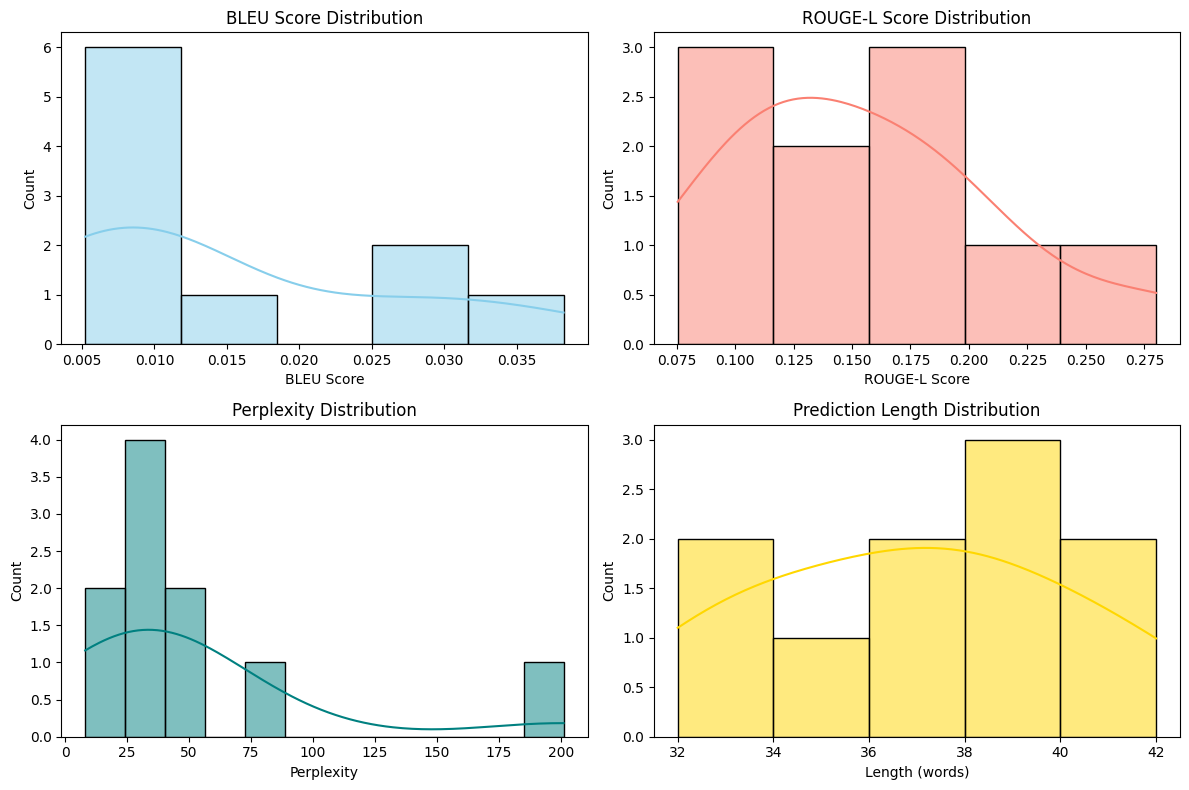

2025-05-30 21:16:54,463 - GPTFineTuning - INFO - Visualizations saved to: models/startup-pitch_20250530_211534/evaluation_metrics.png


INFO:GPTFineTuning:Visualizations saved to: models/startup-pitch_20250530_211534/evaluation_metrics.png


2025-05-30 21:16:54,465 - GPTFineTuning - INFO - Evaluation completed


INFO:GPTFineTuning:Evaluation completed


2025-05-30 21:16:54,467 - GPTFineTuning - INFO - Reports saved to: models/startup-pitch_20250530_211534/evaluation_report.json and models/startup-pitch_20250530_211534/evaluation_report.txt


INFO:GPTFineTuning:Reports saved to: models/startup-pitch_20250530_211534/evaluation_report.json and models/startup-pitch_20250530_211534/evaluation_report.txt


2025-05-30 21:16:54,468 - GPTFineTuning - INFO - Pipeline completed successfully


INFO:GPTFineTuning:Pipeline completed successfully


2025-05-30 21:16:54,469 - GPTFineTuning - INFO - Final metrics:


INFO:GPTFineTuning:Final metrics:


2025-05-30 21:16:54,471 - GPTFineTuning - INFO -   Perplexity: 52.8317


INFO:GPTFineTuning:  Perplexity: 52.8317


2025-05-30 21:16:54,472 - GPTFineTuning - INFO -   BLEU Score: 0.0153


INFO:GPTFineTuning:  BLEU Score: 0.0153


2025-05-30 21:16:54,473 - GPTFineTuning - INFO -   ROUGE-1: 0.1550


INFO:GPTFineTuning:  ROUGE-1: 0.1550


2025-05-30 21:16:54,483 - GPTFineTuning - INFO - Loading model from: models/startup-pitch_20250530_211534


INFO:GPTFineTuning:Loading model from: models/startup-pitch_20250530_211534


2025-05-30 21:16:54,853 - GPTFineTuning - INFO - Model loaded successfully


INFO:GPTFineTuning:Model loaded successfully



Sample Generated Pitches:

Prompt: Our startup
Generated: Our startup connects entrepreneurs with mentors for entrepreneurship through mentorship programs for startup founders.

The program allows startups to test their skills by helping them build apps using AI.

The program offers free mentorship to teens in tech careers.


--------------------------------------------------

Prompt: We are building
Generated: We are buildinga smart thermostat that automatically adjusts humidity to match the energy needs of rural areas.

"We've builta smart thermostat that automatically adjusts humidity to match the energy needs of rural areas," says Brian Gee,
--------------------------------------------------

Prompt: Our solution
Generated: Our solutionautomates water conservation by distributing renewable energy to households.

Solar panels reduce energy costs by 50 percent for households in low-income areas.

Solar panels reduce greenhouse gas emissions by 60 percent for households in developing

In [78]:
if __name__ == "__main__":
    result = main()
    if result["success"]:
        print("\nPipeline completed successfully!")
        print(f"Model saved at: {result['model_path']}")
        print("\nFinal Metrics:")
        for key, value in result["metrics"].items():
            print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")
    else:
        print("\nPipeline failed!")
        print(f"Error: {result['error']}")